# Import libaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# 1. Data Acquisition and Preprocessing

In [2]:
# Load the CSV file
df = pd.read_csv("./Stock_Data/clean_stocks.csv") 
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.set_index('Date', inplace=True)
df.dropna(inplace=True)  # Remove any initial NaNs
df

,Ticker,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2023-02-07,AAPL,150.639999,155.229996,150.639999,154.649994,154.414230,83322600
2023-02-07,GOOG,103.629997,108.669998,103.547997,108.040001,108.040001,33738800
2023-02-07,MSFT,260.529999,268.769989,260.079987,267.559998,266.891510,50841400
2023-02-07,NFLX,358.510010,364.179993,354.179993,362.950012,362.950012,6289400
2023-02-08,GOOG,102.690002,103.580002,98.455002,100.000000,100.000000,73546000
...,...,...,...,...,...,...,...
2023-05-04,NFLX,319.010010,323.609985,317.950012,320.779999,320.779999,3879700
2023-05-04,GOOG,106.160004,106.300003,104.699997,105.209999,105.209999,19780600
2023-05-05,MSFT,305.720001,311.970001,304.269989,310.649994,310.649994,28181200


# 2. Exploratory Data Analysis (EDA)

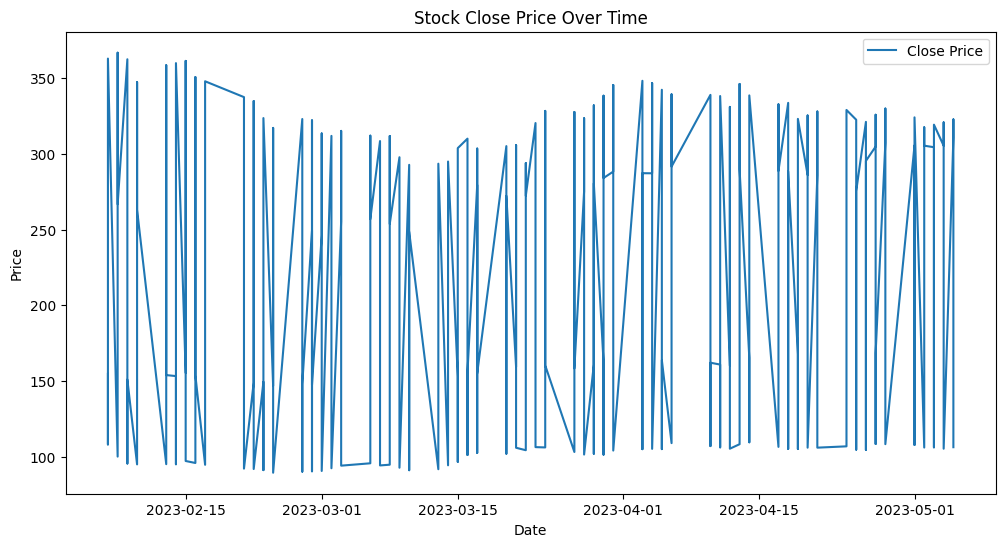

In [3]:
# Visualize Close Price
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price')
plt.title('Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

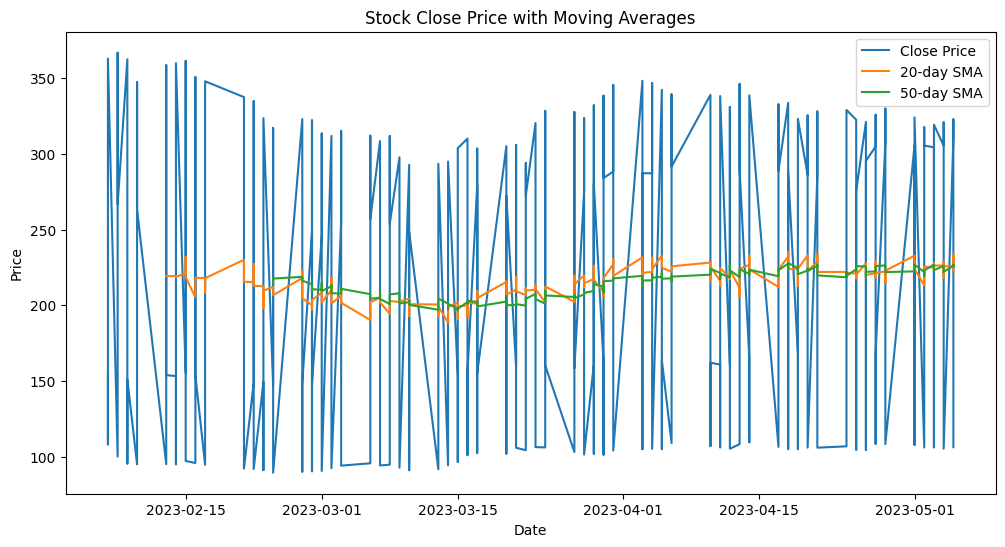

In [4]:
# Calculate and Plot Moving Averages
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['SMA_20'], label='20-day SMA')
plt.plot(df['SMA_50'], label='50-day SMA')
plt.title('Stock Close Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

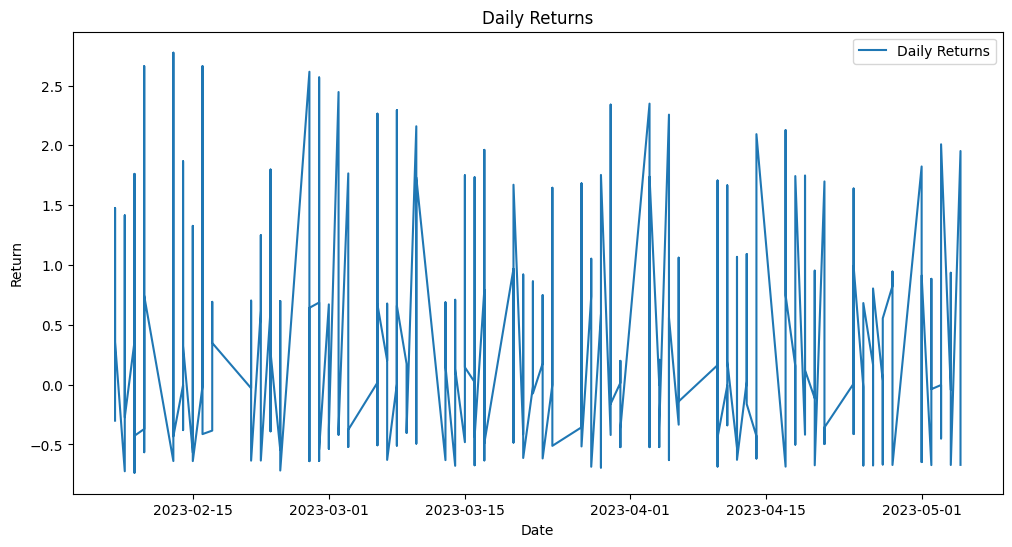

In [5]:
# Calculate and Plot Daily Returns
df['Daily_Return'] = df['Close'].pct_change()
plt.figure(figsize=(12, 6))
plt.plot(df['Daily_Return'], label='Daily Returns')
plt.title('Daily Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()

# 3. Feature Engineering

In [6]:
df['High_Low_Ratio'] = df['High'] / df['Low']
df['Close_Open_Ratio'] = df['Close'] / df['Open']
df['Volatility_20'] = df['Close'].rolling(window=20).std()
df['Volume_Change'] = df['Volume'].pct_change()
df['Close_Lag_1'] = df['Close'].shift(1)
df['Close_Lag_2'] = df['Close'].shift(2)

In [7]:
# RSI (Relative Strength Index)
delta = df['Close'].diff()
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0
roll_up14 = up.rolling(window=14).mean()
roll_down14 = down.abs().rolling(window=14).mean()
RS = roll_up14 / roll_down14
df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

In [8]:
# MACD (Moving Average Convergence Divergence)
exp12 = df['Close'].ewm(span=12, adjust=False).mean()
exp26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp12 - exp26
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

In [9]:
df.dropna(inplace=True)  # Remove NaNs created by feature engineering

# 4. Time Series Analysis and Modeling (ARIMA)

In [10]:
model_arima = ARIMA(df['Close'], order=(5, 1, 0))
model_arima_fit = model_arima.fit()
forecast_arima = model_arima_fit.forecast(steps=30)

c:\Users\lualg\anaconda3\envs\streamlit_pycaret\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lualg\anaconda3\envs\streamlit_pycaret\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lualg\anaconda3\envs\streamlit_pycaret\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lualg\anaconda3\envs\streamlit_pycaret\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results w

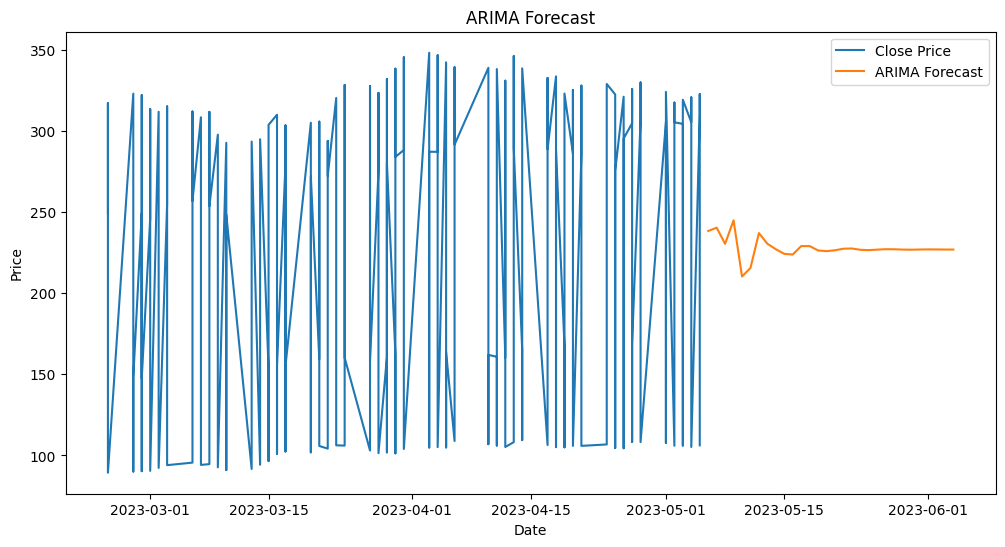

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price')
plt.plot(pd.date_range(df.index[-1], periods=31, freq='D')[1:], forecast_arima, label='ARIMA Forecast')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# 5. Predictive Modeling (Random Forest)

In [12]:
features = ['Close_Lag_1', 'Close_Lag_2', 'Volume', 'RSI', 'MACD']
target = 'Close'
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
predictions_rf = model_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, predictions_rf)
print(f"Random Forest MSE: {mse_rf}")

Random Forest MSE: 1617.1396853974202


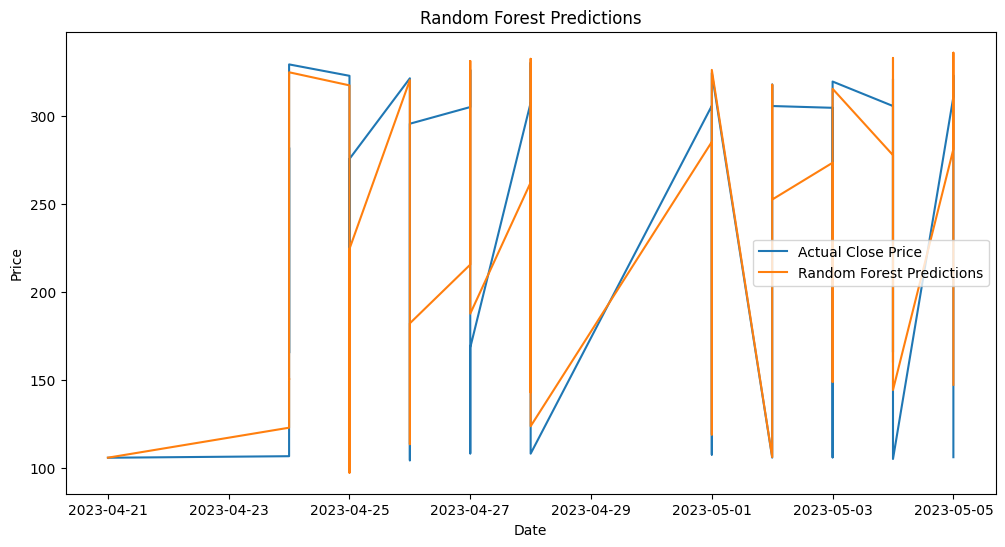

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Close Price')
plt.plot(y_test.index, predictions_rf, label='Random Forest Predictions')
plt.title('Random Forest Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# 6. Predictive Modeling (Linear Regression)

In [14]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
predictions_lr = model_lr.predict(X_test)
mse_lr = mean_squared_error(y_test, predictions_lr)
print(f"Linear Regression MSE: {mse_lr}")

Linear Regression MSE: 1542.3467871241755


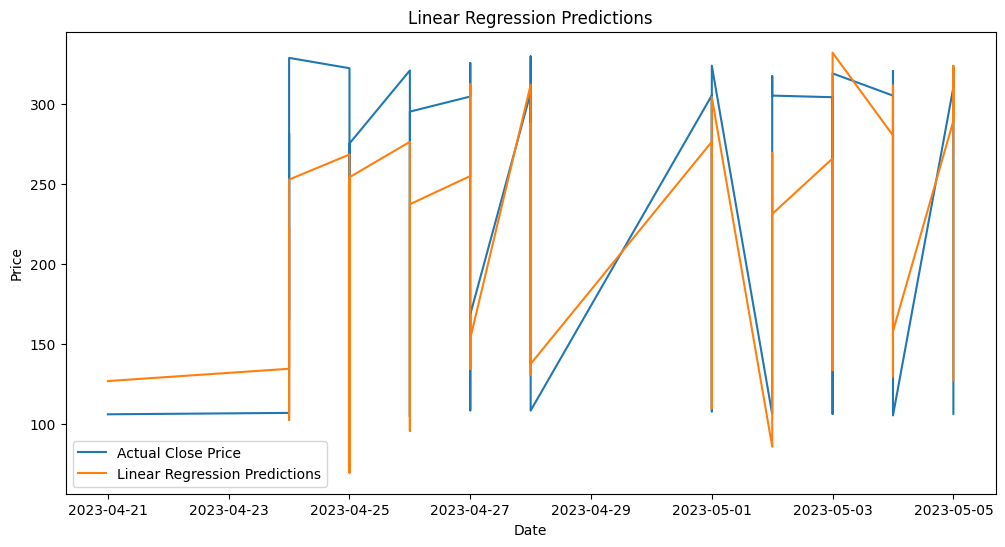

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Close Price')
plt.plot(y_test.index, predictions_lr, label='Linear Regression Predictions')
plt.title('Linear Regression Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()